# Chubby, or not chubby? That is the question.

### Dependencies

In [1]:
# Handling dataframes and arrays
import pandas as pd
import numpy as np

# Visualizations and image handling
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import collections
import cv2
import glob
import random
from skimage import io

# Image preprocessing and data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Local machine configuration and file handling
import os
import shutil

# Deep learning modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Saving cache
import pickle

Using TensorFlow backend.
C:\Users\Windows\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Windows\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Windows\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Windows\Anaconda3\lib\site-packages\tensorflow\python\framework\d

### Variables

In [2]:
# Local paths to the celebA images and subdirectories 
main_dir = 'C:/Users/Windows/Documents/McGill/ycbs229/final project/Kaggle_celeb_faces_dataset/'
img_dir = main_dir + 'img_align_celeba/img_align_celeba/'

CMY_attr_file = main_dir + 'list_attr_celeba_CMY.csv'
CMY_partition_attr_filepaths_file = main_dir + 'list_attr_celeba_CMY_filepaths.csv'

train_dir = main_dir + 'train/'
test_dir = main_dir + 'test/'
val_dir = main_dir + 'validation/'

train_dir_1 = main_dir + 'train/chubby_m_y/'
train_dir_0 = main_dir + 'train/notchubby_m_y/'
test_dir_1 = main_dir + 'test/chubby_m_y/'
test_dir_0 = main_dir + 'test/notchubby_m_y/'
val_dir_1 = main_dir + 'validation/chubby_m_y/'
val_dir_0 = main_dir + 'validation/notchubby_m_y/'

augmentation_dir = main_dir + 'augmentation/'

# Image configs
IMG_WIDTH = 178
IMG_HEIGHT = 218
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Model configs
BATCH_SIZE = 16
NUM_EPOCHS = 10

class_weight = {0: 1.,
                1: 50.}

### Analysis

Each image of contained in the celebA dataset posted on Kaggle was given a series of 40 attributes to describe it. We start off our analysis by looking at the "list_attr_celeba.csv" file, which stores all the attributes corresponding to each celebrity images. <br><br> By looking at the shape, we indeed have 40 attribute variables, for all 202599 celebrity images.

In [22]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_dir + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

For this project, we are focusing on training a CNN algorithm to recognize the "chubbyness" on a face. We have to remember that the final objective of this project is to predict on my own face if I am "chubby", relatively to celebrity standards of face chubbyness. <br><br> To compare apples with apples, we have to select more criterias to make sure that the training dataset is reflecting my gender and my age. With that in mind, we decided to keep the attributes: <br><br> 

- "Chubby" = 0/1 (Not Chubby vs Chubby)<br>
- "Male" = 1 (Male)<br>
- "Young" = 1 (Young)<br><br>

We then create our Y variable, called "C_M_Y" (Chubby_Male_Young). It is a binary variable tagging if the image represents a 'Chubby Young Male'=1 or a 'Not_Chubby Young Male'=0. This way, we can compare the young male celibrities to my own face.

In [97]:
# Defining criteria for Chubby-Males-Young (C_M_Y) binary variable

def Chubby_Male_Young_flag(row):
    if row['Chubby'] == 1 and row['Male'] == 1 and row['Young'] == 1 :
        val = 1
    elif row['Chubby'] == 0 and row['Male'] == 1 and row['Young'] == 1 :
        val = 0
    else:
        val = -1
    return val

df_attr['C_M_Y'] = df_attr.apply(Chubby_Male_Young_flag, axis=1)

We make sure that the above rule is working by printing the 10 first observations of the filtered attribute dataframe. From the table output, we can see that the rule is working, by attributing "1" to Chubby Young Males, and "0" to Not_Chubby Young Males.

In [105]:
# Validate that the filter rules work

pd.set_option('display.max_columns', None)
df_attr[['Chubby', 'Male', 'Young', 'C_M_Y']].loc[df_attr['C_M_Y']>-1].head(10)

Chubby  Male  Young  C_M_Y
image_id                              
000003.jpg       0     1      1      0
000007.jpg       0     1      1      0
000008.jpg       0     1      1      0
000012.jpg       0     1      1      0
000013.jpg       0     1      1      0
000016.jpg       0     1      1      0
000020.jpg       1     1      1      1
000023.jpg       0     1      1      0
000025.jpg       0     1      1      0
000033.jpg       0     1      1      0

We then look at the distribution of the filtered dataset. We can see on the vertical bar graph that the available image dataset after filtering is highly unbalanced. We have a total of 53447 observations, and only 2446 of these observations are corresponding to the attributes "Chubby" = 1, "Young" = 1 and "Male" = 1. We will keep that in mind for later image preprocessing steps...

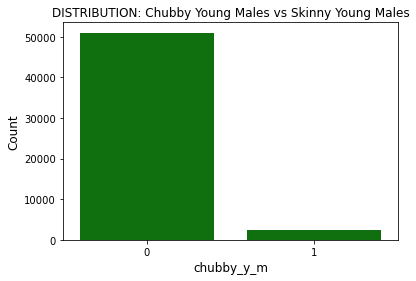

Counter({0: 51001, 1: 2446})
df shape: (53447, 41)


In [116]:
# Chubby + Male + Young dataset distribution
# Counter of Skinny_y_m(0) and Chubby_y_m(1)

df_attr_CMY = df_attr.loc[df_attr['C_M_Y']>-1]

plt.title('DISTRIBUTION: Chubby Young Males vs Skinny Young Males')
cplot = sns.countplot(x='C_M_Y', data=df_attr_CMY, color="g")

plt.ylabel("Count", size=12)
plt.xlabel("chubby_y_m", size=12)
plt.show()

counter = collections.Counter(df_attr_CMY['C_M_Y'])
print(counter)
print(f'df shape: {df_attr_CMY.shape}')

We then print an example of a Chubby Young Male (C_M_Y=1). We can see that the shape of the face is somewhat round, hence chubby, and that it is a young male. So far so good.

Example image: Chubby Young Male


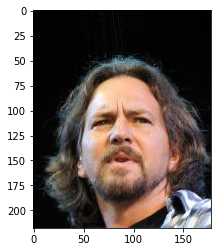

In [104]:
# plot 000020.jpg because it was flagged in previous output as Chubby Young Male

img = load_img(img_dir + '000020.jpg')
plt.imshow(img)
print("Example image: Chubby Young Male")

### Train test validation split

Now that we have a clearer idea of the problems we need to solve, we need to create, manually, a local directory structure of each images used for train, test and validation. <br><br> To do so, since the celebA dataset is composed of images and csv files, we need to link the images corresponding to the attribute filter 'C_M_Y=1' or 'C_M_Y=0', and move them to the right sub directories. We also use the 'partition' variable within the "list_eval_partition.csv" file to configure the file move.<br><br> 

In other words, out of the 202,599 images contained in the celebA dataset, we need to move the 53,447 C_M_Y images to a structured local file directory composed of 3 subfolders in which we create 2 other subfolders as follows:<br><br>

- train
 - train_dir_1 (*images of Chubby Young Males used for training*)
 - train_dir_0 (*images of Not_Chubby Young Males used for training*)
- validation
 - val_dir_1 (*images of Chubby Young Males used for validation*)
 - val_dir_0 (*images of Not_Chubby Young Males used for validation*)
- test
 - test_dir_1 (*images of Chubby Young Males used for testing*)
 - test_dir_0 (*images of Not_Chubby Young Males used for testing*) <br><br>
 
To solve this file filtering/moving problem, we join the 'list_attr_celeba.csv' dataframe and the 'list_eval_partition.csv' dataframe on image_id. We then create 2 functions to append the 'destination directory' lookup variable (*dest_dir*) and 'origin directory' lookup variable (*ori_dir*).<br><br>

Then, we create a csv file "list_attr_celeba_CMY_filepaths.csv" to store our lookup table.

In [179]:
# Built in dataset partitions of celebA:
# 80% training
# 10% validation
# 10% testing

# Recomended partition
df_partition = pd.read_csv(main_dir + 'list_eval_partition.csv')

# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_partition_attr = df_partition.join(df_attr['C_M_Y'], how='inner').loc[df_attr['C_M_Y']>-1]

def destination_dir(row):
    if row['partition'] == 0 and row['C_M_Y'] == 1 :
        val = train_dir_1
    elif row['partition'] == 0 and row['C_M_Y'] == 0 :
        val = train_dir_0
    elif row['partition'] == 1 and row['C_M_Y'] == 1 :
        val = val_dir_1
    elif row['partition'] == 1 and row['C_M_Y'] == 0 :
        val = val_dir_0
    elif row['partition'] == 2 and row['C_M_Y'] == 1 :
        val = test_dir_1
    elif row['partition'] == 2 and row['C_M_Y'] == 0 :
        val = test_dir_0
    return val

def origin_dir(row):
    val = img_dir
    return val

df_partition_attr['dest_dir'] = df_partition_attr.apply(destination_dir, axis=1)
df_partition_attr['ori_dir'] = df_partition_attr.apply(origin_dir, axis=1)

df_partition_attr.head(10)

#df_partition_attr.to_csv(main_dir + 'list_attr_celeba_CMY_filepaths.csv')

partition  C_M_Y  \
image_id                       
000003.jpg          0      0   
000007.jpg          0      0   
000008.jpg          0      0   
000012.jpg          0      0   
000013.jpg          0      0   
000016.jpg          0      0   
000020.jpg          0      1   
000023.jpg          0      0   
000025.jpg          0      0   
000033.jpg          0      0   

                                                     dest_dir  \
image_id                                                        
000003.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000007.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000008.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000012.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000013.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000016.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000020.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000023.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000025.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   
000033.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...   

                                                      ori_dir  
image_id                                                       
000003.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000007.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000008.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000012.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000013.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000016.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000020.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000023.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000025.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...  
000033.jpg  C:/Users/Windows/Documents/McGill/ycbs229/fina...

We validate that we still have 53,447 images before writting our move script, and verify the proportions withing the default partition. As we can see, 43,446 images are for training (81%), 5,218 images are for validation (9.7%), and 4,783 images are for testing (8.9%), for a total of 53,447 images. 

In [182]:
df_partition_attr_filepaths = pd.read_csv(CMY_partition_attr_filepaths_file)
df_partition_attr_filepaths['partition'].value_counts().sort_index()

# Train = 81%
# Validation = 9.7%
# Test = 8.9%

0    43446
1     5218
2     4783
Name: partition, dtype: int64

We can now write our file moving script, grabbing the 53,447 images used for modeling phase to the directory structure we manually created in the past steps.

In [187]:
def move(src, dest):
    shutil.move(src, dest)

#you could use '\\' or '/' for delimiting folder, move calls shutil.move
df_partition_attr_filepaths.apply(lambda row: move(row['ori_filepath'], row['dest_dir']), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
53442    None
53443    None
53444    None
53445    None
53446    None
Length: 53447, dtype: object

### Image pre-processing and data augmentation

In the analysis phase, we discovered that the celebA dataset was highly unbalanced when keeping only Young Males and comparing them on the Chubby variable. We recall that the proportion is (0: 51001, 1: 2446), which skews highly in favor of Not_Chubby observations. In order to try to fix this unbalanced problem, we augment the Chubby Young Males (C_M_Y=1) dataset by creating fake and slightly modified versions of the original celebrity images. We do this augmentation process using the ImageDataGenerator function of the Keras API. Then, we loop the process for each original images. It creates about 38k images, and dumps them into a folder we called "augmentation".

In [205]:
# loop data augmentation on unbalanced data and dump photos in a folder called "augmentation"
# Configuring the loop break function to 'i > 2400' will create about 38k pictures to balance the training dataset.

# create a data generator and configure how to augment each images
datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# loop augmentation function
dataset = []
chubby_males_young_photos = os.listdir(train_dir_1)
for i, image_name in enumerate(chubby_males_young_photos):    
   if (image_name.split('.')[1] == 'jpg'):        
       image = io.imread(train_dir_1 + image_name)        
       image = Image.fromarray(image, 'RGB')         
       dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir=augmentation_dir,
                          save_prefix='aug',
                          save_format='jpeg'):    
  i += 1    
  if i > 2400:        
     break

Here is a screenshot taken of the folder "augmentation" to show an example of how the augmented images were created:

Examples of AUGMENTED IMAGES: Chubby Young Male


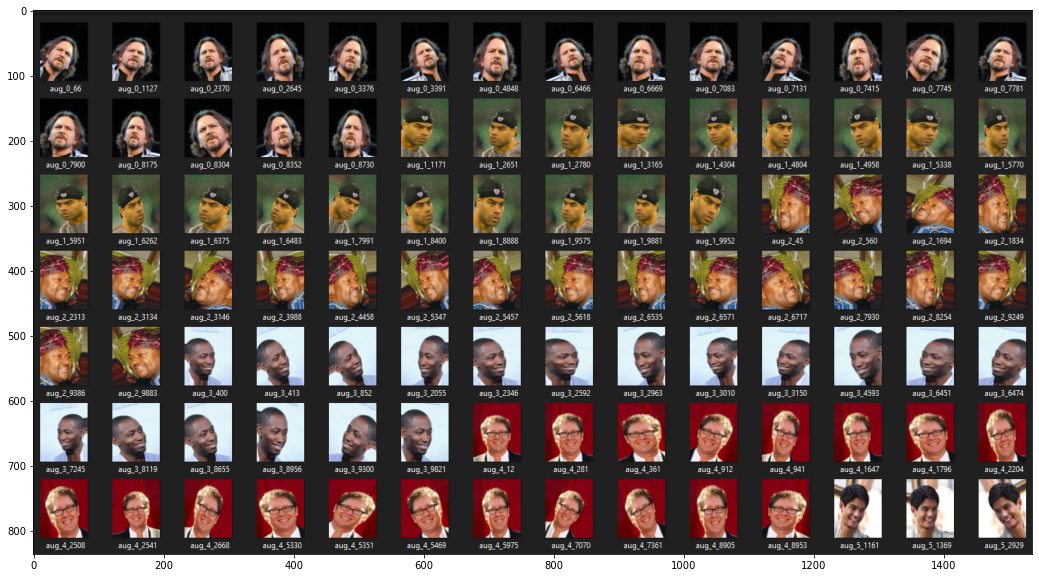

In [20]:
augmented_img = load_img(main_dir + 'augmented_dataset_examples.png')
plt.figure(figsize=(20, 10))
plt.imshow(augmented_img)
print("Examples of AUGMENTED IMAGES: Chubby Young Male")

We manually added the augmented images to the train_dir_1 folder, in order to balance the training dataset with about 40k images for each Chubby = 1 and Chubby = 0 datasets. We use the flow_from_directory function of Keras API to load the images for each partition. We then confirm that the iterator works. We can see that now, 81,998 images are ready for training.

In [6]:
datagen = ImageDataGenerator()

# load and iterate training dataset
train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=16)
# load and iterate validation dataset
val_it = datagen.flow_from_directory(val_dir, class_mode='binary', batch_size=16)
# load and iterate test dataset
test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=16)

# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 81998 images belonging to 2 classes.
Found 5218 images belonging to 2 classes.
Found 4783 images belonging to 2 classes.
Batch shape=(16, 256, 256, 3), min=0.000, max=255.000


### Modeling: CNN algorithm

Finally, we create a sequential model using the Keras API. We design it with 1 layer of Conv2D 256x256 pixels, with a kernel size of 3x3 and 3 color channels. We fix the activation function to Rectified linear (ReLU), and grab the maximum value for each patch of the feature map by configuring the MaxPooling2D to 2x2.<br><br>

We then add another layer with the same configurations, but this time, we add a dropout to the value of 0.2. This has the effect of dropping random nodes at each batch process.<br><br>

We flatten the 3 dimension feature maps to 1 dimension feature vectors. We then connect 64 nodes to 1 output node, which is our Y prediction (Chubby or Not_Chubby young male). Since our prediction is either 1 or 0, we used Sigmoid as the activation function of our output node.<br><br>

As a loss function, to compute the cross-entropy between true labels and predicted labels, we use the binary_crossentropy loss function, as it is recommended for binary output predictions.<br><br>

To correct the weights of each node, we use the Adaptive Moment Estimation (adam) optimizer. We selected ADAM because it is efficient. We had problems training the algorithm on our local machine, so we had to make choices to be more efficient with our memory. To do this, we reduced the batch_size to 16 and selected the ADAM optimizer. It still took about 4.5 hours to train on 10 epochs.<br><br>

We configured the class weights to 50 times to 1, meaning that the algorithm would be rewarded by 50 for correct answers on Chubby=1, and by 1 for correct answers on Chubby=0.<br><br>

In [7]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit_generator(train_it, epochs=10, validation_data=val_it, validation_steps=8, class_weight=class_weight)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5125/5125 [==============================] - 1382s 270ms/step - loss: 0.3517 - acc: 0.5050 - val_loss: 0.7100 - val_acc: 0.9553
Epoch 2/10
5125/5125 [==============================] - 1385s 270ms/step - loss: 0.3515 - acc: 0.5050 - val_loss: 0.7313 - val_acc: 0.9553
Epoch 3/10
5125/5125 [==============================] - 1383s 270ms/step - loss: 0.3501 - acc: 0.5050 - val_loss: 0.7313 - val_acc: 0.9553
Epoch 4/10
5125/5125 [==============================] - 1385s 270ms/step - loss: 0.3506 - acc: 0.5050 - val_loss: 0.7313 - val_acc: 0.9553
Epoch 5/10
5125/5125 [==============================] - 1385s 270ms/step - loss: 0.3498 - acc: 0.5050 - val_loss: 0.7313 - val_acc: 0.9553
Epoch 6/10
5125/5125 [==============================] - 1385s 270ms/st

### Conclusion

Our project did not go as planned! But how fun it was to play with all these tools. We wanted to test the algorithm on a picture of my face, to predict if I'm chubby relatively to celebrity standards...but we did not get enough time to tune the algorithm for better results. We spent too much time on handling image datasets, as it was a first attempt at this kind of problem. We learned a lot! Here is a list of the learning we got from this project:<br><br>

- We should shuffle the datasets before training
- We should reduce the quality of the pictures to reduce the ressources used in the modeling phase
- We should probably apply black and white to pictures to reduce the ressources used in the modeling phase, particularly to this kind of project where the shape of the face is the only real factor of prediction, while colors probably have no impact on the accuracy of the prediction
- We should try more optimizers once we have a leaner dataset
- We should investigate the fit_generator process from the Keras API, as we didn't fully understand it's underlying computations
- We should apply a better balance to not only training dataset, but also test and validation, using Stratify
- We should be careful with data augmentation, because it affects the shapes of the faces, which is probably highly affecting the quality of the training dataset when it comes to predicting if the face is round or not<br><br>

Last but not least, we learned that we LOVE computer vision problems. They are inherently visual problems to solve; making them fun to work with and practically limitless in terms of the possibilities. I look forward to putting more time on this project to fix the problems making this current model to fail at predicting Chubby or Not Chubby.<br><br>

Thank you for reading!<br>
Maxime Kogovsek